In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Mounted at /content/drive


In [2]:
# 2. Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/DXG Historical Data.csv')

In [3]:
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df=df[::-1]
df1=df.reset_index()['Price']

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = int(len(df1)) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [9]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 4s 81ms/step - loss: 0.0356 - val_loss: 0.0049
Epoch 2/100
21/21 [==============================] - 2s 83ms/step - loss: 0.0064 - val_loss: 1.5301e-04
Epoch 3/100
21/21 [==============================] - 2s 83ms/step - loss: 0.0012 - val_loss: 1.3335e-04
Epoch 4/100
21/21 [==============================] - 2s 88ms/step - loss: 7.1022e-04 - val_loss: 9.0135e-05
Epoch 5/100
21/21 [==============================] - 1s 52ms/step - loss: 6.3025e-04 - val_loss: 7.8345e-05
Epoch 6/100
21/21 [==============================] - 1s 51ms/step - loss: 6.0386e-04 - val_loss: 7.7825e-05
Epoch 7/100
21/21 [==============================] - 1s 54ms/step - loss: 5.8530e-04 - val_loss: 9.6424e-05
Epoch 8/100
21/21 [==============================] - 1s 52ms/step - loss: 5.6850e-04 - val_loss: 7.9673e-05
Epoch 9/100
21/21 [==============================] - 1s 52ms/step - loss: 5.4390e-04 - val_loss: 8.9176e-05
Epoch 10/100
21/21 [========================

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

2/2 [==============================] - 0s 25ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 18405.442259826727


In [14]:
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_pred, ytest)
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))*100
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing MAPE: 99.99837281025663
Testing MAE: 18399.667512160733


In [15]:
x_input = test_data[len(test_data)-time_step:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

print(lst_output)


[[0.31938284635543823], [0.3139497935771942], [0.30787742137908936], [0.3014894425868988], [0.2949502766132355], [0.2883296310901642], [0.2816663086414337], [0.27498605847358704], [0.26830846071243286], [0.2616497874259949], [0.2550235986709595], [0.248441681265831], [0.241914302110672], [0.2354503870010376], [0.22905777394771576], [0.22274331748485565], [0.21651290357112885], [0.2103714942932129], [0.20432327687740326], [0.19837172329425812], [0.19251948595046997], [0.18676868081092834], [0.18112076818943024], [0.17557673156261444], [0.17013698816299438], [0.16480155289173126], [0.15957002341747284], [0.1544416844844818], [0.14941556751728058], [0.1444903463125229], [0.13966456055641174], [0.13493655622005463], [0.1303044855594635], [0.12576644122600555], [0.12132038176059723], [0.11696422845125198], [0.11269586533308029], [0.10851310193538666], [0.10441378504037857], [0.10039577633142471], [0.09645690023899078], [0.09259501844644547], [0.0888080820441246], [0.08509398996829987], [0.0

In [16]:
future_predict = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
future_predict

array([[19517.89512724],
       [19300.51379584],
       [19057.55271906],
       [18801.9639384 ],
       [18540.32602254],
       [18275.42803659],
       [18008.82250842],
       [17741.53968698],
       [17474.36299072],
       [17207.94347972],
       [16942.82370406],
       [16679.47526496],
       [16418.30895032],
       [16159.68188926],
       [15903.90768764],
       [15651.26060155],
       [15401.97613349],
       [15156.25282102],
       [14914.25819881],
       [14676.13118355],
       [14441.97790042],
       [14211.88301106],
       [13985.90494395],
       [13764.08304888],
       [13546.43401969],
       [13332.9584526 ],
       [13123.64024995],
       [12918.45079374],
       [12717.35133038],
       [12520.28879728],
       [12327.20476597],
       [12138.03305726],
       [11952.69974127],
       [11771.12850325],
       [11593.23766259],
       [11418.94404814],
       [11248.16299826],
       [11080.80687023],
       [10916.78951187],
       [10756.02536722],


In [17]:
# Append the last 100 values of test_data to the beginning of y_pred
last_100_test_data = scaler.inverse_transform(test_data[:101])
y_pred_with_test_data = np.append(last_100_test_data, y_pred)

In [21]:
print(y_pred_with_test_data.shape)
scaler.inverse_transform(test_data).shape

(156,)


(156, 1)

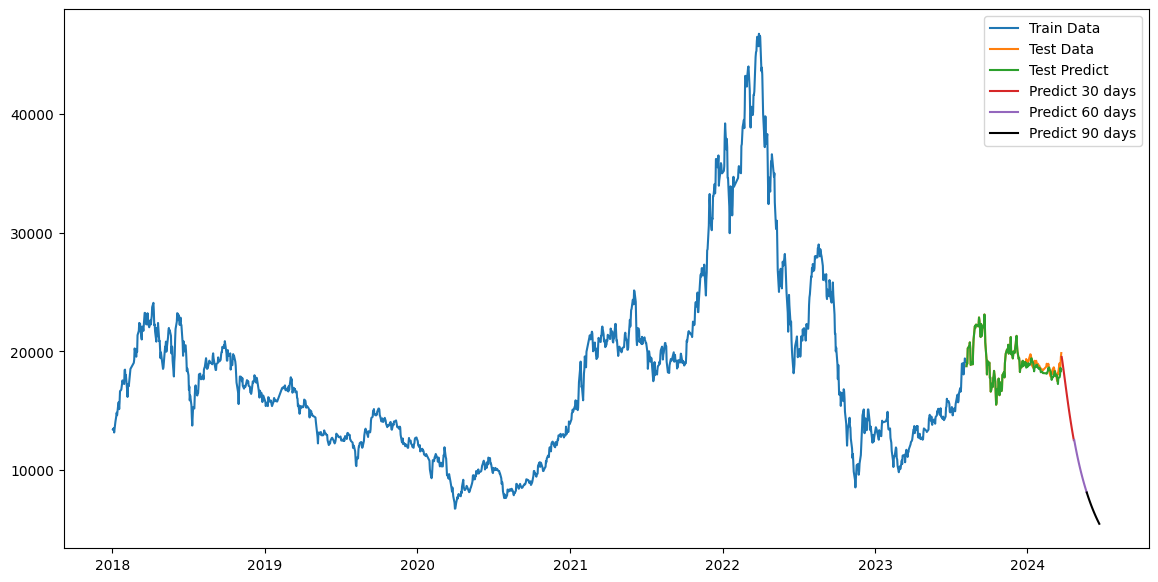

In [22]:
# Plot results
plt.figure(figsize=(14, 7))

# Plot train data
plt.plot(df['Date'][:train_size], scaler.inverse_transform(train_data), label='Train Data')

# Plot test data
plt.plot(df['Date'][train_size:], scaler.inverse_transform(test_data), label='Test Data')

# Plot test predict data with appended last 100 test data
plt.plot(df['Date'][train_size:], y_pred_with_test_data, label='Test Predict')

# Plot future predictions
last_test_date = df['Date'].iloc[-1]
future_predict_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=30)
future_predict_dates_1 = pd.date_range(start=last_test_date + pd.Timedelta(days=31), periods=31)
future_predict_dates_2 = pd.date_range(start=last_test_date + pd.Timedelta(days=61), periods=31)

plt.plot(future_predict_dates, future_predict[0:30], label='Predict 30 days')
plt.plot(future_predict_dates_1, future_predict[29:60], label='Predict 60 days')
plt.plot(future_predict_dates_2, future_predict[59:90], label='Predict 90 days', color='black')
# Display the legend
plt.legend()

# Display the plot
plt.show()